<a href="https://colab.research.google.com/github/alimomennasab/CS4210/blob/main/4210FinalProjectKNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CS4210-02 Machine Learning
## Fall 2024 Semester Project
K-nearest neighbors model that classifies fish/shrimp from an image
### Members:
- Ali Momennasab
- Denise Thuong
- Eli Tolentino
- Armin Erika Polanco
- Sarah Choe
- Damian Varela


##Imports

In [ ]:
import kagglehub
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import PIL

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from pathlib import Path
from skimage.transform import resize

##Data Preprocessing

In [ ]:
# Download latest version
path = kagglehub.dataset_download("crowww/a-large-scale-fish-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/crowww/a-large-scale-fish-dataset/versions/2


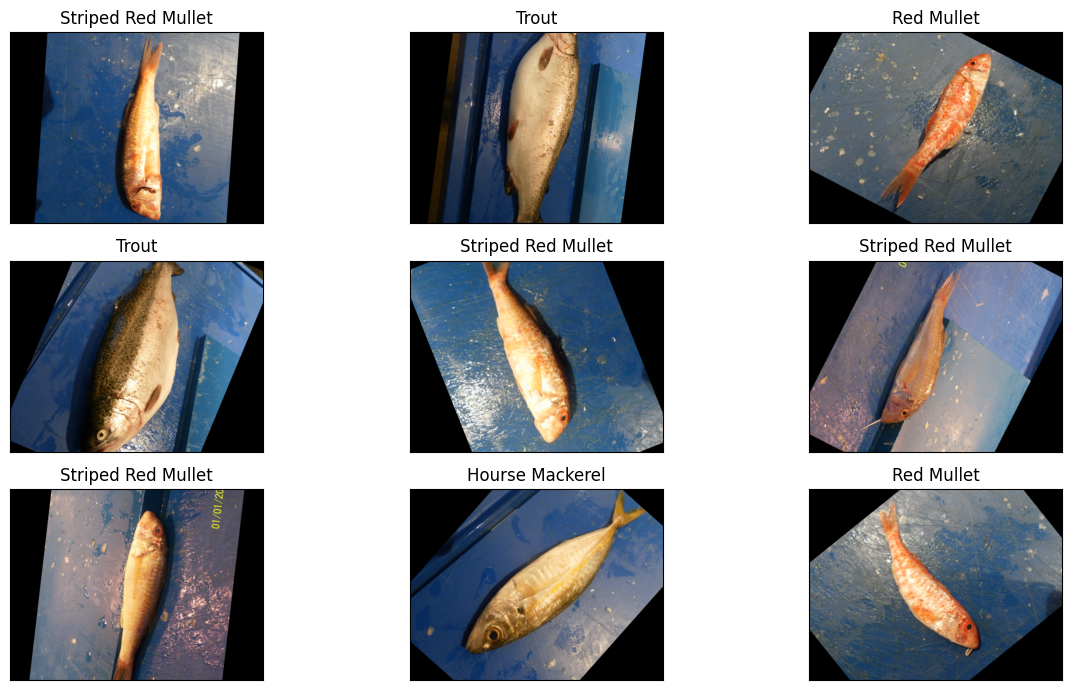

In [ ]:
# Cleaning dataset
direc = Path(path)
filepaths = list(direc.glob(r'**/*.png'))
Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))

filepaths = pd.Series(filepaths, name='FilePaths').astype(str)
Labels = pd.Series(Labels, name='Labels').astype(str)

img_df = pd.merge(filepaths, Labels, right_index = True, left_index = True)

img_df = img_df[ img_df['Labels'].apply(lambda x: x[-2:]!='GT') ] # ground truth binary masks not needed for classification

img_df = img_df[img_df['FilePaths'].str.endswith('.png')].reset_index(drop=True) # keep only pngs

# Shuffle images and display 9 random images
img_df=img_df.sample(frac = 1).reset_index(drop=True)
img_df.head()
f,a = plt.subplots(nrows=3, ncols=3,figsize=(13, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(a.flat):
    ax.imshow(plt.imread(img_df.FilePaths[i]))
    ax.set_title(img_df.Labels[i])

plt.tight_layout()
plt.show()

In [ ]:
# Data analysis
img_df.shape

(9281, 2)

In [ ]:
# Data analysis
img_df.columns

Index(['FilePaths', 'Labels'], dtype='object')

In [ ]:
# Delete original, non-augmented photos that have different sizing/resolution
for index in img_df.index:
    try:
        img = plt.imread(img_df.FilePaths[index])
        if img.shape != (445, 590, 3):
            img_df.drop(index, inplace=True)
    except:
        # If we can't read the image, drop it
        img_df.drop(index, inplace=True)

img_df.shape

(9000, 2)

In [ ]:
# Prepare features (X) and labels (y)
X = []
y = []

# Reduce image size for less computational load
smaller_image_shape = (89, 118, 3)

# Load and flatten images
for index in img_df.index:
    img = plt.imread(img_df.FilePaths[index])
    img_smaller_shape = resize(img, smaller_image_shape, anti_aliasing=True)
    X.append(img_smaller_shape.flatten())  # flatten the image into 1D array for KNN
    y.append(img_df.Labels[index])

X = np.array(X)
y = np.array(y)

# Convert labels to numerical format
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=8000, random_state=1)


KeyboardInterrupt: 

##Training

In [ ]:
# Train KNN classifier
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)

KNeighborsClassifier()

##Testing

In [ ]:
predictions = model.predict(X_test)

# evaluation metrics: confusion matrix, accuracy, classification report, kappa
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))
print("Accuracy:", accuracy_score(y_test, predictions))
print("Classification Report:", classification_report(y_test, predictions, target_names=label_encoder.classes_))
print("Kappa:", cohen_kappa_score(y_test, predictions))

Confusion Matrix:
[[ 93   0   0   0   0   1   0   4   0]
 [  2  94   0   1   7   3   0   2   0]
 [  0   0 109   1   1   0   1   0   0]
 [  3   0   1 101   0   1   1   0   0]
 [  5   2   1   0 111   0   0   0   0]
 [ 10   1   2   2   1  93   2   4   0]
 [  4   0   1   1   0   0 105   0   0]
 [  1   2   0   1   2   0   2 109   0]
 [  1  18   4   5   8   5   0   2  69]]
Accuracy: 0.884
Classification Report:                     precision    recall  f1-score   support

   Black Sea Sprat       0.78      0.95      0.86        98
   Gilt-Head Bream       0.80      0.86      0.83       109
   Hourse Mackerel       0.92      0.97      0.95       112
        Red Mullet       0.90      0.94      0.92       107
     Red Sea Bream       0.85      0.93      0.89       119
          Sea Bass       0.90      0.81      0.85       115
            Shrimp       0.95      0.95      0.95       111
Striped Red Mullet       0.90      0.93      0.92       117
             Trout       1.00      0.62      0.76 